# Tutorial

The objective of this tutorial is to get up and running a minimal training run 
for the poregen. We will go through all the steps necessary for this run.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms
import skimage
import lightning
import lightning.pytorch.callbacks as callbacks
import porespy

import poregen.models

[12:41:58] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=91758;file:///home/dfnaiff/miniconda3/envs/ddpmenv/lib/python3.11/site-packages/openpnm/utils/_workspace.py\_workspace.py]8;;\:]8;id=230046;file:///home/dfnaiff/miniconda3/envs/ddpmenv/lib/python3.11/site-packages/openpnm/utils/_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

In [3]:
MAINFOLDER = pathlib.Path("../..") #This leads to the main folder
RAWDATAFOLDER = MAINFOLDER/"saveddata"/"raw" #This leads to the data folder
MODELSPATH = MAINFOLDER/"savedmodels" #This leads to the models folder


We first load our Berea sandstone binarized file.

In [4]:
def load_berea(path):
    """
    This function takes a .raw file of a 1000x1000x1000 binarized 
    sandstone, converts it to an numpy of type uint8, and reshapes it
    to the shape [1000, 1000, 1000].
    *Unless I (Danilo) am wrong*, the format is as following:
    the first axis corresponds to the z direction, 
    the second axis corresponds to the x direction,
    and the third axis corresponds to the y direction.
    ---
    input: path : str
        Path to file
    output: voxel : np.array
        voxel, where 1 corresponds to solid, and 0 corresponds to void.
    """
    with open(path, 'rb') as f:
        voxel = np.fromfile(f, dtype=np.uint8)
    voxel = voxel.reshape((1000, 1000, 1000))
    return voxel
name = "berea/Berea_2d25um_binary.raw"
path = RAWDATAFOLDER/name
voxel = load_berea(path)


In [6]:
voxel.shape

(1000, 1000, 1000)

In [5]:
def reduce_resolution(voxel, block_size, threshold='mean'):
    """
    This is an auxiliary function to reduce 
    """
    mean = skimage.measure.block_reduce(voxel, block_size=block_size, func=np.mean)
    if threshold == 'mean':
        threshold = voxel.mean()
    elif threshold == 'any':
        threshold = 0.0
    reduced_voxel = (mean > threshold).astype(int)
    return reduced_voxel

reduced_voxel = reduce_resolution(voxel, block_size=4, threshold='mean')
train_voxel = reduced_voxel[:200, :, :] #Separate in train voxel 
valid_voxel = reduced_voxel[200:, :, :] #Separate in validation voxeo

Let's plot our berea voxels

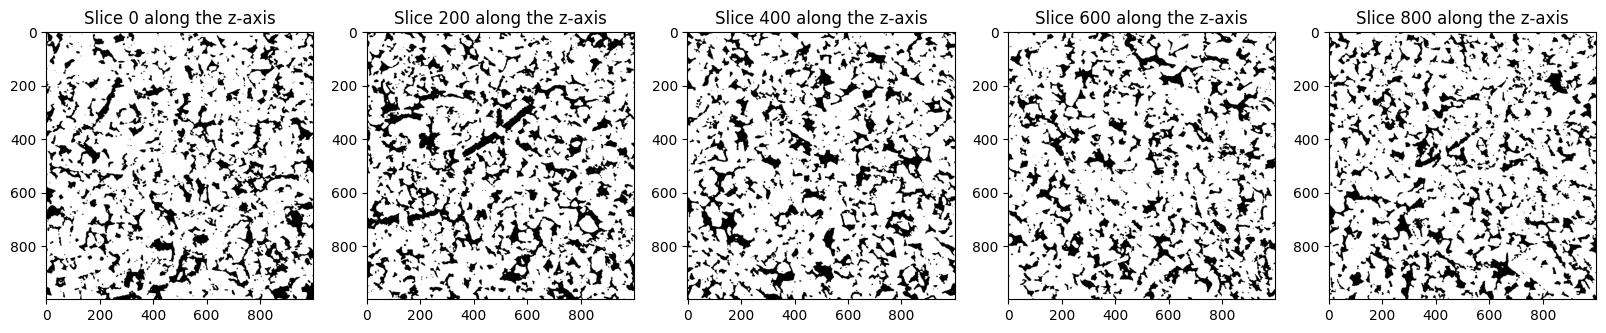

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()
# Generate slices and plot
for axind, sliceind in enumerate(range(0, 1000, 200)):  # Increment of 16 to skip some slices for brevity
    axes[axind].imshow(voxel[sliceind, :, :], cmap='gray')  # alpha for transparency
    axes[axind].set_title(f"Slice {sliceind} along the z-axis")


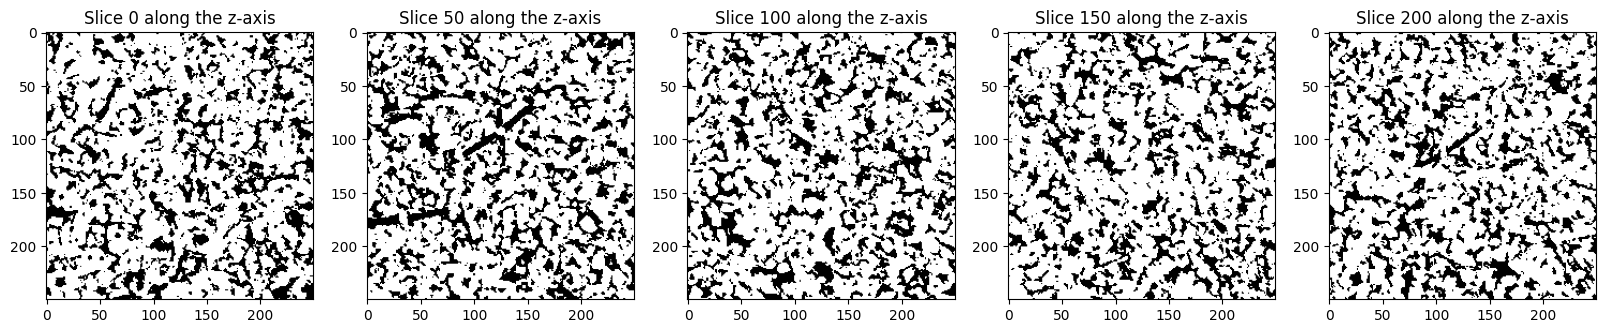

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()
# Generate slices and plot
for axind, sliceind in enumerate(range(0, 250, 50)):  # Increment of 16 to skip some slices for brevity
    axes[axind].imshow(reduced_voxel[sliceind, :, :], cmap='gray')  # alpha for transparency
    axes[axind].set_title(f"Slice {sliceind} along the z-axis")


In [ ]:
class VoxelToSlicesDataset(torch.utils.data.Dataset):
    def __init__(self, voxel, dataset_size=34560, 
                 image_size=128,
                 transform=None):
        """
        Parameters
        ----------
        voxel : np.ndarray
            The original voxel
        dataset_size : int
            The size of the dataset, as in, how many times we sample 
            until we consider a complete a batch
        """
        self.voxel = torch.tensor(voxel, dtype=torch.float32)
        self.dataset_size = dataset_size
        self.image_size = image_size
        self.cropper = transforms.RandomCrop(image_size)
        self.transform = transform

    def get_random_voxel_slice(self):
        i = np.random.randint(self.voxel.shape[0])
        return self.voxel[i]

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        x = self.get_random_voxel_slice() #Get some vertical slice
        x = x.unsqueeze(0) #Unsqueeze so that it has shape [1, image_size, image_size]
        x = self.cropper(x) #Get a random crop from the slice
        if self.transform: #Apply a transformation
            x = self.transform(x)
        return x

In [5]:
batch_size = 16
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

train_dataset = VoxelToSlicesDataset(train_voxel, transform=transform, image_size=48)
val_dataset = VoxelToSlicesDataset(valid_voxel, transform=transform, image_size=48)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

NameError: name 'VoxelToSlicesDataset' is not defined

In [108]:
x = next(iter(train_dataloader))

Text(0.5, 1.0, 'A image of the training dataset')

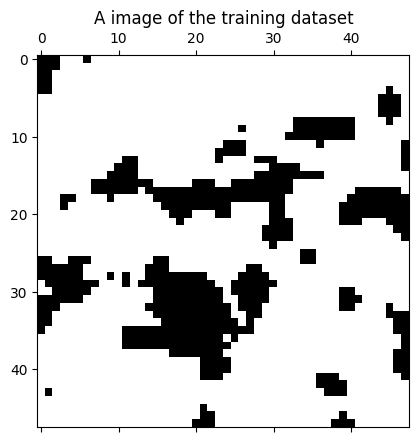

In [112]:
x = next(iter(train_dataloader))
plt.matshow(x[0][0], cmap='gray')
plt.title("A image of the training dataset")

Let's prepare and train our model

In [114]:
model = poregen.models.PUNetUncond(32, dropout=0.2)
scheduler = poregen.models.DDPMScheduler()
module = poregen.models.DDPMModule(model, scheduler, conditional=False,
                                   loss_type="huber",
                                   loss_scaling="constant",
                                   loss_scale_factor=1)

In [117]:
checkpoint_callback = callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=MODELSPATH/"tutorial-0001-berea",
    filename='sample-bead-{epoch:02d}-{val_loss:.6f}',
    save_top_k=3,
    mode='min',
)


In [118]:
module.optimizer = torch.optim.Adam(module.parameters(),
                                    lr=2*1e-5)
module.lr_scheduler = None

In [119]:
trainer = lightning.Trainer(max_epochs=20,
                            callbacks=[checkpoint_callback])
trainer.fit(model=module,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lcadame/miniconda3/envs/ddpm_env/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory ../../savedmodels/tutorial-0001-berea exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | PUNetUncond | 2.8 M 
1 | scheduler   | DDPMScheduler    | 1     
2 | sampler     | DDPMSampler      | 2.8 M 
3 | loss_metric | HuberLoss        | 0     
-------------------------------------------------
2.8 M     Trainable params
16        Non-trainable params
2.8 M     Total params
11.341    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/lcadame/miniconda3/envs/ddpm_env/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [120]:
model = poregen.models.PUNetUncond(32, dropout=0.2)
scheduler = poregen.models.DDPMScheduler()


In [129]:
checkpoint_path = MAINFOLDER/\
    "savedmodels/tutorial-0001-berea/sample-bead-epoch=16-val_loss=0.022220.ckpt"
loaded_module = poregen.models.DDPMModule.load_from_checkpoint(checkpoint_path,
                                                               model=model,
                                                               scheduler=scheduler,
                                                               conditional=False,
                                                               loss_type="huber",
                                                               loss_scaling="constant",
                                                               loss_scale_factor=1.0)

In [130]:
loaded_module.model.eval()
loaded_module.model.to("cuda")
sampler = poregen.models.DDPMSampler(loaded_module.model, 
                                     loaded_module.scheduler, shape=[1, 48, 48],
                                     noise_type=2)

In [131]:
samples_from_ddpm = torch.cat([
                        sampler.sample(nsamples=16, device="cuda").cpu() for i in range(4)],
                    axis=0)
samples_from_validation = torch.stack([
                            val_dataset[i] for i in range(16*4)
                        ], axis=0)

In [132]:
def binarize(x):
    dims = list(range(1, len(x.shape)))
    return x > (x.mean(dim=dims, keepdim=True))

samples_from_ddpm_binarized = binarize(samples_from_ddpm)
samples_from_validation_binarized = binarize(samples_from_validation)


In [133]:
def scaled_tpc(tpc):
    x = tpc.distance
    porosity = tpc.probability_scaled[0]
    ub = porosity
    lb = porosity**2
    y0 = tpc.probability_scaled
    y = (y0 - lb)/(ub - lb)
    return x, y

ys_ddpm_list = []
ys_valid_list = []

for i in range(64):
    # tpc = porespy.metrics.two_point_correlation(x_net[i])
    # plt.plot(tpc.distance, tpc.pdf, color='red', alpha=0.1)
    blue_label = "ddpm" if i == 0 else None
    red_label = "validation" if i == 0 else None
    tpc = porespy.metrics.two_point_correlation((~samples_from_ddpm_binarized[i][0]).numpy())
    xs_ddpm, ys_ddpm = scaled_tpc(tpc)
    tpc = porespy.metrics.two_point_correlation((~samples_from_validation_binarized[i][0]).numpy())
    xs_valid, ys_valid = scaled_tpc(tpc)
    ys_ddpm_list.append(ys_ddpm)
    ys_valid_list.append(ys_valid)
is_noise = np.array([ysd[1] < 0.5 for ysd in ys_ddpm_list])

samples_from_ddpm_binarized_filtered = samples_from_ddpm_binarized[~is_noise]

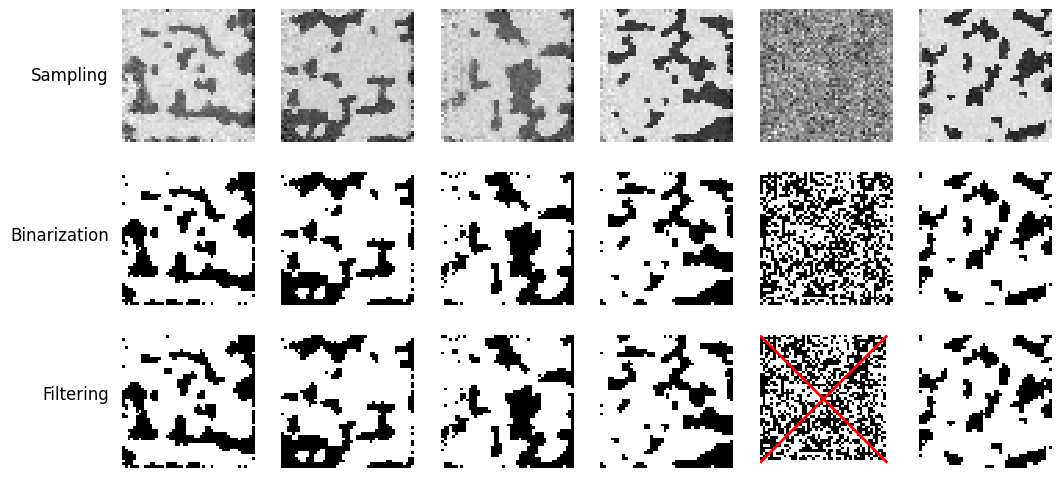

In [140]:
# fig, axes = plt.subplots(4, 4, figsize=(12, 12))
# axes = axes.flatten()
# for i in range(axes.shape[0]):
#     axes[i].matshow(xplt64b_filtered[i][0].detach().numpy(), cmap="gray_r")
# fig.savefig(FIGURESPATH/"04122022-grid6x6-04-large0filtered.jpg")

fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for ax in axes.flatten():
    ax.axis('off')

# Define your row labels
row_labels = ["Sampling", "Binarization", "Filtering"]

# Set the positions for the labels
label_x_position = -0.1  # Adjust as needed
label_y_positions = [0.5, -0.7, -1.9]  # Adjust as needed based on your figure size and layout

for i, label in enumerate(row_labels):
    # Add text to the figure, not to an individual axis
    fig.text(label_x_position, label_y_positions[i], label, va='center', ha='right', fontsize=12, transform=axes[0, 0].transAxes)

for i in range(axes.shape[1]):
    j = i + 10
    cross_out = is_noise[j]
    axes[0, i].matshow(samples_from_ddpm[j][0].detach().numpy(), cmap="gray")
    axes[1, i].matshow(samples_from_ddpm_binarized[j][0].detach().numpy(), cmap="gray")
    axes[2, i].matshow(samples_from_ddpm_binarized[j][0].detach().numpy(), cmap="gray")

    if cross_out:
        # Get the dimensions of the image
        num_rows, num_cols = samples_from_ddpm_binarized[j][0].shape

        # Draw two lines (diagonal cross)
        axes[2, i].plot([0, num_cols], [0, num_rows], color='red', lw=2)  # From top-left to bottom-right
        axes[2, i].plot([0, num_cols], [num_rows, 0], color='red', lw=2)  # From bottom-left to top-right
# fig.savefig(FIGURESPATH/"06122022-filteing-process.jpg")


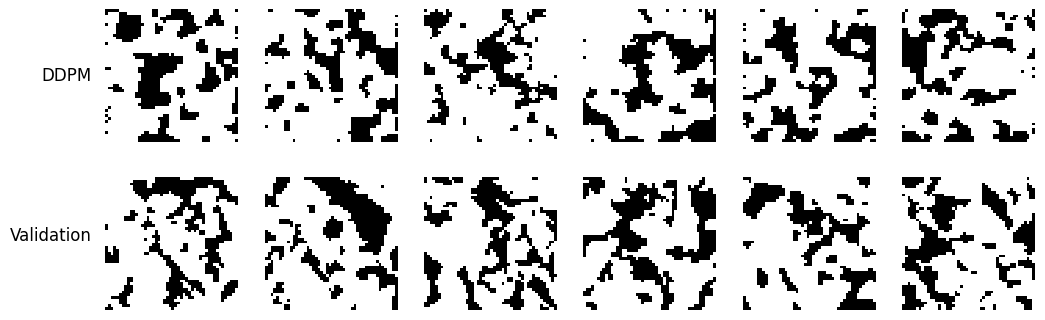

In [141]:
# fig, axes = plt.subplots(4, 4, figsize=(12, 12))
# axes = axes.flatten()
# for i in range(axes.shape[0]):
#     axes[i].matshow(xplt64b_filtered[i][0].detach().numpy(), cmap="gray_r")
# fig.savefig(FIGURESPATH/"04122022-grid6x6-04-large0filtered.jpg")

fig, axes = plt.subplots(2, 6, figsize=(12, 4))

# Define your row labels
row_labels = ["DDPM", "Validation"]

# Set the positions for the labels
label_x_position = -0.1  # Adjust as needed
label_y_positions = [0.5, -0.7]  # Adjust as needed based on your figure size and layout

for i, label in enumerate(row_labels):
    # Add text to the figure, not to an individual axis
    fig.text(label_x_position, label_y_positions[i], label, va='center', ha='right', fontsize=12, transform=axes[0, 0].transAxes)

for ax in axes.flatten():
    ax.axis('off')

for i in range(axes.shape[1]):
    axes[0, i].matshow(samples_from_ddpm_binarized_filtered[i][0].detach().numpy(), cmap="gray")
    axes[1, i].matshow(samples_from_validation_binarized[i][0].detach().numpy(), cmap="gray")

# fig.savefig(FIGURESPATH/"06122022-ddpm-validation-comparison.jpg")


In [142]:
ys_ddpm_list_filtered = [ysd for i, ysd in enumerate(ys_ddpm_list) if not is_noise[i]]
mean_ys_ddpm_filtered = np.mean(np.stack(ys_ddpm_list_filtered, axis=0), 0)
std_ys_ddpm_filtered = np.std(np.stack(ys_ddpm_list_filtered, axis=0), 0)
mean_ys_valid = np.mean(np.stack(ys_valid_list, axis=0), 0)
std_ys_valid = np.std(np.stack(ys_valid_list, axis=0), 0)


Text(0.5, 1.0, 'Comparison of two point correlation')

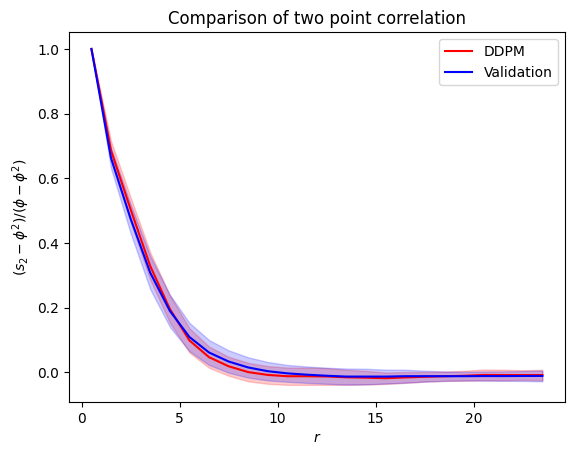

In [143]:
plt.fill_between(xs_ddpm,
                 y1=mean_ys_ddpm_filtered-1*std_ys_ddpm_filtered,
                 y2=mean_ys_ddpm_filtered+1*std_ys_ddpm_filtered, color='red', alpha=0.2)
plt.fill_between(xs_valid,
                 y1=mean_ys_valid-1*std_ys_valid,
                 y2=mean_ys_valid+1*std_ys_valid, color='blue', alpha=0.2)
plt.plot(xs_ddpm, mean_ys_ddpm_filtered, color='red', label='DDPM')
plt.plot(xs_valid, mean_ys_valid, color='blue', label='Validation')
plt.xlabel(r"$r$")
plt.ylabel(r"$(s_2 - \phi^2)/(\phi - \phi^2)$")
plt.legend()
plt.title("Comparison of two point correlation")
# plt.savefig(FIGURESPATH/"06122022-tpc.jpg")


In [144]:
porosity_net = [porespy.metrics.porosity(~x) for x in samples_from_ddpm_binarized.squeeze(1)]
porosity_net_filtered = [porespy.metrics.porosity(~x) for x in samples_from_ddpm_binarized_filtered.squeeze(1)]
porosity_true = [porespy.metrics.porosity(~x) for x in samples_from_validation_binarized.squeeze(1)]

Text(0.5, 1.0, 'Porosity histogram')

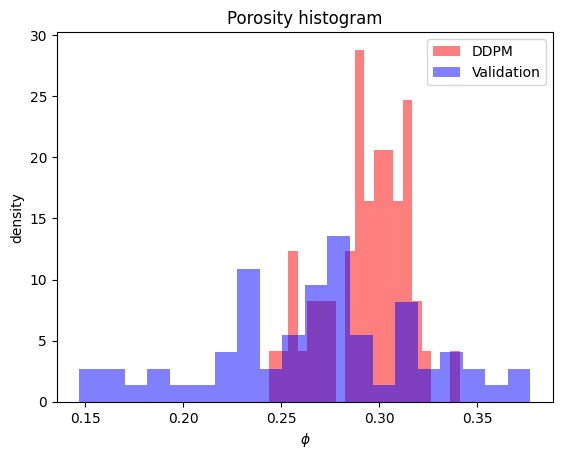

In [145]:
plt.hist(porosity_net_filtered, bins=20, alpha=0.5, color='red', density=True, label='DDPM');
plt.hist(porosity_true, bins=20, alpha=0.5, color='blue', density=True, label='Validation');
plt.xlabel(r"$\phi$")
plt.ylabel("density")
plt.legend()
plt.title("Porosity histogram")
# plt.savefig(FIGURESPATH/"06122022-porosity.jpg")
